In [0]:
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, AveragePooling2D, MaxPooling2D, UpSampling2D, Input, Reshape
from keras import backend as K
from keras.optimizers import Nadam, Adam, SGD
from keras.metrics import categorical_accuracy, binary_accuracy
#from keras_contrib.losses import jaccard
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) 

In [0]:
def iou(y_true, y_pred, smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [0]:
# To read the images in numerical order
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [0]:
# Initializing all the images into 4d arrays.

filelist_trainx = sorted(glob.glob('trainx/*.jpg'), key=numericalSort)
#filelist_trainx.sort()
X_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainx])

filelist_trainy = sorted(glob.glob('trainy/*.jpg'), key=numericalSort)
#filelist_trainy.sort()
Y_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainy])

filelist_testx = sorted(glob.glob('testx/*.jpg'), key=numericalSort)
#filelist_testx.sort()
X_test = np.array([np.array(Image.open(fname)) for fname in filelist_testx])

filelist_testy = sorted(glob.glob('testy/*.jpg'), key=numericalSort)
#filelist_testy.sort()
Y_test = np.array([np.array(Image.open(fname)) for fname in filelist_testy])

filelist_valx = sorted(glob.glob('validationx/*.jpg'), key=numericalSort)
#filelist_valx.sort()
X_val = np.array([np.array(Image.open(fname)) for fname in filelist_valx])

filelist_valy = sorted(glob.glob('validationy/*.jpg'), key=numericalSort)
#filelist_valy.sort()
Y_val = np.array([np.array(Image.open(fname)) for fname in filelist_valy])

y = [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


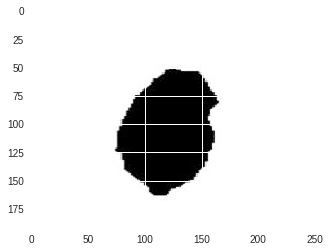

In [8]:
index = 100
plt.imshow(Y_val[index])
print ("y = " + str(np.squeeze(Y_val[:, index])))

In [0]:
def UnPooling2x2ZeroFilled(x):
    
    out = tf.concat([x, tf.zeros_like(x)], 3)
    out = tf.concat([out, tf.zeros_like(out)], 2)

    sh = x.get_shape().as_list()
    if None not in sh[1:]:
        out_size = [-1, sh[1] * 2, sh[2] * 2, sh[3]]
        return tf.reshape(out, out_size)
    else:
        shv = tf.shape(x)
        ret = tf.reshape(out, tf.stack([-1, shv[1] * 2, shv[2] * 2, sh[3]]))
        return ret

In [0]:
# Pipe Line

(x_train, y_train), (x_test, y_test), (x_val, y_val) = (X_train, Y_train), (X_test, Y_test), (X_val, Y_val)

def model_seg():
  
  # Convolution Layers (BatchNorm after non-linear activation)
  
  img_input = Input(shape= (192, 256, 3))
  x = Conv2D(16, (3, 3), padding='same', name='conv1')(img_input)
  x = BatchNormalization(name='bn1')(x)
  x = Activation('relu')(x)
  x = Conv2D(32, (3, 3), padding='same', name='conv2')(x)
  x = BatchNormalization(name='bn2')(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x)
  x = Conv2D(64, (3, 3), padding='same', name='conv3')(x)
  x = BatchNormalization(name='bn3')(x)
  x = Activation('relu')(x)
  x = Conv2D(64, (3, 3), padding='same', name='conv4')(x)
  x = BatchNormalization(name='bn4')(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x)
  x = Conv2D(128, (3, 3), padding='same', name='conv5')(x)
  x = BatchNormalization(name='bn5')(x)
  x = Activation('relu')(x)
  x = Conv2D(128, (4, 4), padding='same', name='conv6')(x)
  x = BatchNormalization(name='bn6')(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x)
  x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
  x = BatchNormalization(name='bn7')(x)
  x = Dropout(0.5)(x)
  x = Activation('relu')(x)
  x = Conv2D(256, (3, 3), padding='same', name='conv8')(x)
  x = BatchNormalization(name='bn8')(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x)
  x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
  x = BatchNormalization(name='bn9')(x)
  x = Activation('relu')(x)
  x = Dense(1024, activation = 'relu', name='fc1')(x)
  x = Dense(1024, activation = 'relu', name='fc2')(x)
  
  # Deconvolution Layers (BatchNorm after non-linear activation)
  
  x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv1')(x)
  x = BatchNormalization(name='bn19')(x)
  x = Activation('relu')(x)
  x = UpSampling2D()(x)
  x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv2')(x)
  x = BatchNormalization(name='bn12')(x)
  x = Activation('relu')(x)
  x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv3')(x)
  x = BatchNormalization(name='bn13')(x)
  x = Activation('relu')(x)
  x = UpSampling2D()(x)
  x = Conv2DTranspose(128, (4, 4), padding='same', name='deconv4')(x)
  x = BatchNormalization(name='bn14')(x)
  x = Activation('relu')(x)
  x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv5')(x)
  x = BatchNormalization(name='bn15')(x)
  x = Activation('relu')(x)
  x = UpSampling2D()(x)
  x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv6')(x)
  x = BatchNormalization(name='bn16')(x)
  x = Activation('relu')(x)
  x = Conv2DTranspose(32, (3, 3), padding='same', name='deconv7')(x)
  x = BatchNormalization(name='bn20')(x)
  x = Activation('relu')(x)
  x = UpSampling2D()(x)
  x = Conv2DTranspose(16, (3, 3), padding='same', name='deconv8')(x)
  x = BatchNormalization(name='bn17')(x)
  x = Dropout(0.5)(x)
  x = Activation('relu')(x)
  x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv9')(x)
  x = BatchNormalization(name='bn18')(x)
  x = Activation('sigmoid')(x)
  pred = Reshape((192,256))(x)
  
  model = Model(inputs=img_input, outputs=pred)
  
  model.compile(optimizer= Adam(lr = 0.003), loss= [jaccard_distance], metrics=[iou])
  
  hist = model.fit(x_train, y_train, epochs= 300, batch_size= 16,validation_data=(x_test, y_test), verbose=1)
  
  model.save("model.h5")
  
  accuracy = model.evaluate(x=x_test,y=y_test,batch_size=16)
  print("Accuracy: ",accuracy[1])

In [24]:
model_seg()

Train on 2000 samples, validate on 600 samples
Epoch 1/200
2000/2000 [==============================] - 82s 41ms/step - loss: 0.6329 - iou: 0.3671 - val_loss: 0.7062 - val_iou: 0.2938
Epoch 2/200
2000/2000 [==============================] - 74s 37ms/step - loss: 0.5905 - iou: 0.4095 - val_loss: 0.6382 - val_iou: 0.3618
Epoch 3/200
1808/2000 [==========================>...] - ETA: 6s - loss: 0.5741 - iou: 0.42592000/2000 [==============================] - 74s 37ms/step - loss: 0.5729 - iou: 0.4271 - val_loss: 0.6212 - val_iou: 0.3788
Epoch 4/200
2000/2000 [==============================] - 74s 37ms/step - loss: 0.5653 - iou: 0.4347 - val_loss: 0.6213 - val_iou: 0.3787
Epoch 5/200
2000/2000 [==============================] - 74s 37ms/step - loss: 0.5612 - iou: 0.4388 - val_loss: 0.6165 - val_iou: 0.3835
Epoch 6/200
 832/2000 [===========>..................] - ETA: 38s - loss: 0.5577 - iou: 0.44232000/2000 [==============================] - 75s 38ms/step - loss: 0.5592 - iou: 0.4408 - val

 624/2000 [========>.....................] - ETA: 45s - loss: 0.5638 - iou: 0.43622000/2000 [==============================] - 75s 37ms/step - loss: 0.5520 - iou: 0.4480 - val_loss: 0.6107 - val_iou: 0.3893
Epoch 52/200
2000/2000 [==============================] - 75s 37ms/step - loss: 0.5518 - iou: 0.4482 - val_loss: 0.6107 - val_iou: 0.3893
Epoch 53/200
2000/2000 [==============================] - 74s 37ms/step - loss: 0.5517 - iou: 0.4483 - val_loss: 0.6104 - val_iou: 0.3896
Epoch 54/200
 624/2000 [========>.....................] - ETA: 45s - loss: 0.5587 - iou: 0.44132000/2000 [==============================] - 75s 37ms/step - loss: 0.5519 - iou: 0.4481 - val_loss: 0.6109 - val_iou: 0.3891
Epoch 55/200
2000/2000 [==============================] - 75s 37ms/step - loss: 0.5520 - iou: 0.4480 - val_loss: 0.6109 - val_iou: 0.3891
Epoch 56/200
2000/2000 [==============================] - 75s 37ms/step - loss: 0.5518 - iou: 0.4482 - val_loss: 0.6107 - val_iou: 0.3893
Epoch 57/200
 624/200

 608/2000 [========>.....................] - ETA: 46s - loss: 0.5435 - iou: 0.45652000/2000 [==============================] - 75s 38ms/step - loss: 0.5506 - iou: 0.4494 - val_loss: 0.6109 - val_iou: 0.3891
Epoch 103/200
2000/2000 [==============================] - 75s 38ms/step - loss: 0.5509 - iou: 0.4491 - val_loss: 0.6303 - val_iou: 0.3697
Epoch 104/200
2000/2000 [==============================] - 75s 38ms/step - loss: 0.5508 - iou: 0.4492 - val_loss: 0.6109 - val_iou: 0.3891
Epoch 105/200
 608/2000 [========>.....................] - ETA: 46s - loss: 0.5582 - iou: 0.44182000/2000 [==============================] - 75s 38ms/step - loss: 0.5505 - iou: 0.4495 - val_loss: 0.6107 - val_iou: 0.3893
Epoch 106/200
2000/2000 [==============================] - 75s 38ms/step - loss: 0.5506 - iou: 0.4494 - val_loss: 0.6104 - val_iou: 0.3896
Epoch 107/200
2000/2000 [==============================] - 75s 38ms/step - loss: 0.5507 - iou: 0.4493 - val_loss: 0.6110 - val_iou: 0.3890
Epoch 108/200
 6

 608/2000 [========>.....................] - ETA: 46s - loss: 0.5418 - iou: 0.45822000/2000 [==============================] - 75s 38ms/step - loss: 0.5498 - iou: 0.4502 - val_loss: 0.6115 - val_iou: 0.3885
Epoch 154/200
2000/2000 [==============================] - 75s 38ms/step - loss: 0.5499 - iou: 0.4501 - val_loss: 0.6116 - val_iou: 0.3884
Epoch 155/200
2000/2000 [==============================] - 75s 37ms/step - loss: 0.5499 - iou: 0.4501 - val_loss: 0.6118 - val_iou: 0.3882
Epoch 156/200
 608/2000 [========>.....................] - ETA: 46s - loss: 0.5360 - iou: 0.46402000/2000 [==============================] - 75s 37ms/step - loss: 0.5498 - iou: 0.4502 - val_loss: 0.6120 - val_iou: 0.3880
Epoch 157/200
2000/2000 [==============================] - 75s 37ms/step - loss: 0.5498 - iou: 0.4502 - val_loss: 0.6124 - val_iou: 0.3876
Epoch 158/200
2000/2000 [==============================] - 74s 37ms/step - loss: 0.5497 - iou: 0.4503 - val_loss: 0.6115 - val_iou: 0.3885
Epoch 159/200
 6

In [36]:
  (x_train, y_train), (x_test, y_test), (x_val, y_val) = (X_train, Y_train), (X_test, Y_test), (X_val, Y_val)
  # Convolution Layers (BatchNorm after non-linear activation)
  
  img_input = Input(shape= (192, 256, 3))
  x = Conv2D(16, (3, 3), padding='same', name='conv1')(img_input)
  x = BatchNormalization(name='bn1')(x)
  x = Activation('relu')(x)
  x = Conv2D(32, (3, 3), padding='same', name='conv2')(x)
  x = BatchNormalization(name='bn2')(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x)
  x = Conv2D(64, (3, 3), padding='same', name='conv3')(x)
  x = BatchNormalization(name='bn3')(x)
  x = Activation('relu')(x)
  x = Conv2D(64, (3, 3), padding='same', name='conv4')(x)
  x = BatchNormalization(name='bn4')(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x)
  x = Conv2D(128, (3, 3), padding='same', name='conv5')(x)
  x = BatchNormalization(name='bn5')(x)
  x = Activation('relu')(x)
  x = Conv2D(128, (4, 4), padding='same', name='conv6')(x)
  x = BatchNormalization(name='bn6')(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x)
  x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
  x = BatchNormalization(name='bn7')(x)
  x = Dropout(0.5)(x)
  x = Activation('relu')(x)
  x = Conv2D(256, (3, 3), padding='same', name='conv8')(x)
  x = BatchNormalization(name='bn8')(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x)
  x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
  x = BatchNormalization(name='bn9')(x)
  x = Activation('relu')(x)
  x = Dense(1024, activation = 'relu', name='fc1')(x)
  x = Dense(1024, activation = 'relu', name='fc2')(x)
  
  # Deconvolution Layers (BatchNorm after non-linear activation)
  
  x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv1')(x)
  x = BatchNormalization(name='bn19')(x)
  x = Activation('relu')(x)
  x = UpSampling2D()(x)
  x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv2')(x)
  x = BatchNormalization(name='bn12')(x)
  x = Activation('relu')(x)
  x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv3')(x)
  x = BatchNormalization(name='bn13')(x)
  x = Activation('relu')(x)
  x = UpSampling2D()(x)
  x = Conv2DTranspose(128, (4, 4), padding='same', name='deconv4')(x)
  x = BatchNormalization(name='bn14')(x)
  x = Activation('relu')(x)
  x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv5')(x)
  x = BatchNormalization(name='bn15')(x)
  x = Activation('relu')(x)
  x = UpSampling2D()(x)
  x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv6')(x)
  x = BatchNormalization(name='bn16')(x)
  x = Activation('relu')(x)
  x = Conv2DTranspose(32, (3, 3), padding='same', name='deconv7')(x)
  x = BatchNormalization(name='bn20')(x)
  x = Activation('relu')(x)
  x = UpSampling2D()(x)
  x = Conv2DTranspose(16, (3, 3), padding='same', name='deconv8')(x)
  x = BatchNormalization(name='bn17')(x)
  x = Dropout(0.5)(x)
  x = Activation('relu')(x)
  x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv9')(x)
  x = BatchNormalization(name='bn18')(x)
  x = Activation('sigmoid')(x)
  pred = Reshape((192,256))(x)
  
  model = Model(inputs=img_input, outputs=pred)
  
  model.compile(optimizer= Adam(lr = 0.003), loss= [jaccard_distance], metrics=[iou])
  model.load_weights("model.h5")
  predictions_valid = model.predict(x_val, batch_size=16, verbose=1)
  accuracy = model.evaluate(x=x_val,y=y_val,batch_size=16)
  print("Accuracy: ",accuracy[1])

150/150 [==============================] - 2s 16ms/step
Accuracy:  0.49426538586616514


In [0]:
index = 45
predict_input = x_val[index]
ground_truth = y_val[index]

In [0]:
predictions =model.predict(predict_input.reshape(1,192,256,3), batch_size=1)
prediction = predictions.reshape(192, 256)

Text(0.5,1,'Ground Turth')

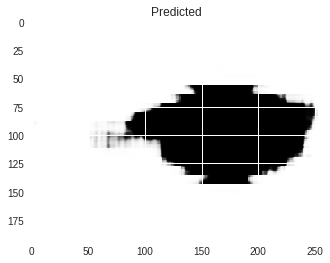

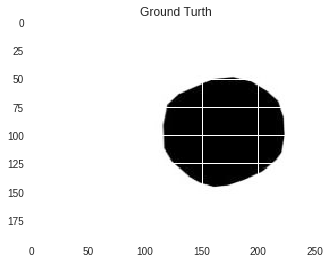

In [68]:
#index = 45
plt.figure()
plt.imshow(prediction)
plt.title('Predicted')
plt.figure()
plt.imshow(ground_truth)
plt.title('Ground Turth')